In [25]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Model
from tensorflow.keras import backend as k 
from tqdm import tqdm
import GAN
from matplotlib import pyplot as plt 
from build_discriminator import build_discriminator
from build_generator import build_generator
import numpy as np 

In [28]:
def train(models,x_train,params):
    generator, discriminator, adversarial = models

    (batch_size, latent_size, n_critic,clip_value, train_steps, model_name) = params

    save_interval = 250 #500단계 마다 생성기 이미지 저장 

    noise_input = np.random.uniform(-1,1,size=[16,latent_size]) #훈련 동안 생성기 변화 확인 
    train_size = x_train.shape[0]

    real_labels = np.ones((batch_size, 1))

    for i in tqdm(range(train_steps)):
        loss = 0 
        acc = 0 
        for _ in range(n_critic): #판별기 5회 학습 
            """
            데이터 생성 
            """
            #진짜 데이터 
            rand_indexes = np.random.randint(0,train_size,size=batch_size)
            real_images = x_train[rand_indexes]
            #가짜 데이터 
            noise = np.random.uniform(-1,1,size=[batch_size,latent_size])
            fake_images = generator.predict(noise)
            
            """
            학습 
            """
            #학습 - 진짜 데이터와 가짜 데이터 나눠서 학습 함 
            real_loss, real_acc = \
                discriminator.train_on_batch(real_images,real_labels)
            fake_loss, fake_acc = \
                discriminator.train_on_batch(fake_images,-real_labels)
            #가짜 데이터 라벨을 -1로 넣음 

            """
            학습 후 평가 
            """
            loss += 0.5 * (real_loss + fake_loss) #loss 두개 평균 
            acc += 0.5 * (real_acc + fake_acc) #acc 평균 
            
            """
            Weights Clipping 
            """
            #weight clip -> 립시츠 상수 만족시키기 위해서
            #각 layer의 weight를 출력한 뒤 cilp 후 다시 세팅 
            for layer in discriminator.layers:
                weights = layer.get_weights()
                weights = [np.clip(weight,-clip_value,clip_value) for weight in weights]
                layer.set_weights(weights)
        loss /= n_critic #판별기 5번 학습 시킨 거 평균 냄 
        acc /= n_critic 
        log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)

        """
        생성기 학습 
        """
        noise = np.random.uniform(-1,1,size=[batch_size,latent_size])
        loss, acc = adversarial.train_on_batch(noise, real_labels)
        log = "%s [adversarial loss :%f, acc :%f" % (log,loss,acc)
        

        if (i+1) % save_interval == 0 : 
            print(log)
            GAN.plot_images(generator,
                    noise_input=noise_input,
                    show=True,
                    step=(i + 1),
                    model_name=model_name)

linear


  1%|          | 249/40000 [02:06<5:37:06,  1.97it/s]

249: [discriminator loss: -40.950558, acc: 0.500000] [adversarial loss :-270.355560, acc :1.000000


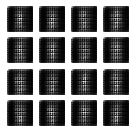

  1%|          | 499/40000 [04:11<5:14:03,  2.10it/s]

499: [discriminator loss: -7.638976, acc: 0.500000] [adversarial loss :-40.972630, acc :1.000000


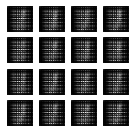

  2%|▏         | 630/40000 [05:17<5:30:34,  1.98it/s]


KeyboardInterrupt: 

In [29]:
# def build_and_train_models():
(x_train,_),(_,_) = mnist.load_data()

# CNN을 위한 데이터 형상을 28,28,1로 조정하고 정규화 
image_size = x_train.shape[1]
x_train = np.reshape(x_train,[-1,image_size,image_size,1])
x_train = x_train.astype('float32')/255

model_name = 'wgan_mnist'

latent_size = 100 #z벡터 차원 수 
n_critic = 5 
clip_value = 0.01 
batch_size = 64 
train_steps = 40000
lr = 5e-5
decay = 6e-8
input_shape = (image_size,image_size,1)

#sasserstein_loss
def wasserstein_loss(y_label,y_pred):
    return -k.mean(y_label*y_pred)

#식별자 모델 구성 
inputs = Input(shape=input_shape,name='discriminator_inputs')
discriminator = GAN.discriminator(inputs,activation='linear')
optimizer = RMSprop(learning_rate=lr)
discriminator.compile(loss = wasserstein_loss,
                        optimizer = optimizer,
                        metrics = ['accuracy'])

#생성자 모델 구성 
input_shape = (latent_size,)
inputs = Input(shape = input_shape, name = 'z_input')
generator = GAN.generator(inputs,image_size)

#적대적 모델 구성 
discriminator.trainable = False
# adversial = generator + discriminator
adversarial = Model(inputs,
                        discriminator(generator(inputs)),
                        name = model_name)
adversarial.compile(loss = wasserstein_loss,
                         optimizer = optimizer,
                         metrics = ['accuracy'])

#판별기와 적대적 네트워크를 훈련 
models = (generator, discriminator, adversarial)
params = (batch_size,latent_size,n_critic,clip_value,train_steps,model_name)
train(models,x_train,params)
